In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb

import gc
from datetime import datetime, timedelta

SEED = 0
START_DATE = '2017-12-01'

In [2]:
%%time
df_train_identity = pd.read_csv('../input/train_identity.csv')
df_test_identity = pd.read_csv('../input/test_identity.csv')
df_train_transaction = pd.read_csv('../input/train_transaction.csv')
df_test_transaction = pd.read_csv('../input/test_transaction.csv')
df_train_merged = pd.merge(df_train_transaction, df_train_identity, how='left', on='TransactionID')
X_train = df_train_merged.drop('isFraud', axis=1)
y_train = df_train_merged['isFraud'].copy()
X_test = pd.merge(df_test_transaction, df_test_identity, how='left', on='TransactionID')

print('Number of Training Examples = {}'.format(df_train_transaction.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test_transaction.shape[0]))
print('Number of Training Examples with Identity = {}'.format(df_train_identity.shape[0]))
print('Number of Test Examples with Identity = {}\n'.format(df_test_identity.shape[0]))
print('Training X Shape = {}'.format(X_train.shape))
print('Training y Shape = {}'.format(y_train.shape))
print('Test X Shape = {}\n'.format(X_test.shape))

del df_train_identity, df_test_identity, df_train_transaction, df_test_transaction, df_train_merged
gc.collect()

Number of Training Examples = 590540
Number of Test Examples = 506691

Number of Training Examples with Identity = 144233
Number of Test Examples with Identity = 141907

Training X Shape = (590540, 433)
Training y Shape = (590540,)
Test X Shape = (506691, 433)

CPU times: user 48.4 s, sys: 18.2 s, total: 1min 6s
Wall time: 1min 6s


74

In [3]:
%%time
startdate = datetime.strptime(START_DATE, '%Y-%m-%d')

for df in [X_train, X_test]:
    df['TransactionDT'] = df['TransactionDT'].apply(lambda x: (startdate + timedelta(seconds=x)))    
    df['hour'] = df['TransactionDT'].dt.hour.values
    df['day'] = df['TransactionDT'].dt.day.values
    df['month'] = df['TransactionDT'].dt.month.values
    
gc.collect()

CPU times: user 1.34 s, sys: 48 ms, total: 1.39 s
Wall time: 1.4 s


110

In [4]:
%%time
v_cols = [col for col in X_train.columns if col.startswith('V')]
c_cols = [col for col in X_train.columns if col.startswith('C')]
d_cols = [col for col in X_train.columns if col.startswith('D') and not col.startswith('De')]

'''
for df in [X_train, X_test]:
    for col in v_cols:
        df[col] = StandardScaler().fit_transform(df[col].values.reshape(-1, 1))
        df[col] = df[col].fillna(df[col].median())

pca = PCA(n_components=200)

components = pca.fit_transform(X_train[v_cols])
X_train = pd.concat([X_train, pd.DataFrame(components, columns=['V{}_PCA'.format(i) for i in range(1, components.shape[1] + 1)])], axis=1)
components = pca.fit_transform(X_test[v_cols])
X_test = pd.concat([X_test, pd.DataFrame(components, columns=['V{}_PCA'.format(i) for i in range(1, components.shape[1] + 1)])], axis=1)
del components
gc.collect()

for df in [X_train, X_test]:
    df.drop(columns=v_cols, inplace=True)'''

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 330 µs


"\nfor df in [X_train, X_test]:\n    for col in v_cols:\n        df[col] = StandardScaler().fit_transform(df[col].values.reshape(-1, 1))\n        df[col] = df[col].fillna(df[col].median())\n\npca = PCA(n_components=200)\n\ncomponents = pca.fit_transform(X_train[v_cols])\nX_train = pd.concat([X_train, pd.DataFrame(components, columns=['V{}_PCA'.format(i) for i in range(1, components.shape[1] + 1)])], axis=1)\ncomponents = pca.fit_transform(X_test[v_cols])\nX_test = pd.concat([X_test, pd.DataFrame(components, columns=['V{}_PCA'.format(i) for i in range(1, components.shape[1] + 1)])], axis=1)\ndel components\ngc.collect()\n\nfor df in [X_train, X_test]:\n    df.drop(columns=v_cols, inplace=True)"

In [5]:
'''id_columns = ['id_{}'.format(i) for i in range(12, 39)]
categorical_features = ['DeviceType', 'DeviceInfo'] + id_columns

#train_title_names = (df_train['Title'].value_counts() < 10)
#df_train['Title'] = df_train['Title'].apply(lambda x: 'Other' if train_title_names.loc[x] == True else x)


X_train[['DeviceInfo', 'DeviceType', 'id_30', 'id_31', 'id_33']]'''

"id_columns = ['id_{}'.format(i) for i in range(12, 39)]\ncategorical_features = ['DeviceType', 'DeviceInfo'] + id_columns\n\n#train_title_names = (df_train['Title'].value_counts() < 10)\n#df_train['Title'] = df_train['Title'].apply(lambda x: 'Other' if train_title_names.loc[x] == True else x)\n\n\nX_train[['DeviceInfo', 'DeviceType', 'id_30', 'id_31', 'id_33']]"

In [6]:
for df in [X_train, X_test]:    
    df['domain_name'] = df['P_emaildomain'].str.split('.', expand=True)[0]
    df['pixels'] = df['id_33'].str.split('x', expand=True)[0].astype(float) * df['id_33'].str.split('x', expand=True)[1].astype(float)
    df.drop(columns=['TransactionDT'], inplace=True)

for feature in X_train.columns:
    if X_train[feature].dtype == 'object' or X_test[feature].dtype == 'object': 
        lbl = LabelEncoder()
        lbl.fit(list(X_train[feature].values) + list(X_test[feature].values))
        X_train[feature] = lbl.transform(list(X_train[feature].values))
        X_test[feature] = lbl.transform(list(X_test[feature].values))

In [7]:
sparse = []

for df in [X_train, X_test]:
    for feature in df.columns:
        counts = df[feature].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.9:
            sparse.append(feature)
            
sparse = list(set(sparse))
sparse

['V305', 'V117', 'V107']

In [8]:
for df in [X_train, X_test]:
    df.drop(columns=sparse, inplace=True)

In [9]:
%%time
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

Memory usage of dataframe is 1959.88 MB
Memory usage after optimization is: 528.27 MB
Decreased by 73.0%
Memory usage of dataframe is 1681.60 MB
Memory usage after optimization is: 460.99 MB
Decreased by 72.6%
CPU times: user 2min 3s, sys: 5min 19s, total: 7min 23s
Wall time: 7min 23s


In [10]:
for df in [X_train, X_test]:
    df['TransactionAmt'] = np.log1p(df['TransactionAmt'])

In [11]:
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    gamma=0.1,
    alpha=4,
    tree_method='gpu_hist'
)

gc.collect()

33

In [12]:
N = 10
skf = StratifiedKFold(n_splits=N, shuffle=True, random_state=SEED)

importance = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=X_train.columns)
score = 0
y_pred = np.zeros(X_test.shape[0])
oof = np.zeros(X_train.shape[0])

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}'.format(fold))
    
    X_tr, X_vl = X_train.iloc[trn_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[trn_idx], y_train.iloc[val_idx]
    
    clf.fit(X_tr, y_tr)
    
    predictions = clf.predict_proba(X_vl)[:, 1]
    importance.iloc[:, fold - 1] = clf.feature_importances_
    oof[val_idx] = predictions
    
    score += roc_auc_score(y_vl, predictions) / N
    print('Fold {} ROC AUC Score {}\n'.format(fold, roc_auc_score(y_vl, predictions)))
    
    y_pred += clf.predict_proba(X_test)[:, 1] / N
    
    del X_tr, X_vl, y_tr, y_vl, predictions
    gc.collect()
    
print('Average ROC AUC Score {}'.format(score))

Fold 1
Fold 1 ROC AUC Score 0.9685203759954352

Fold 2
Fold 2 ROC AUC Score 0.9661274312700432

Fold 3
Fold 3 ROC AUC Score 0.9707693407916296

Fold 4
Fold 4 ROC AUC Score 0.9646962921016439

Fold 5
Fold 5 ROC AUC Score 0.9644510212948144

Fold 6
Fold 6 ROC AUC Score 0.9647965492777779

Fold 7
Fold 7 ROC AUC Score 0.9634785759485651

Fold 8
Fold 8 ROC AUC Score 0.9669692206257329

Fold 9
Fold 9 ROC AUC Score 0.9687761620060729

Fold 10
Fold 10 ROC AUC Score 0.9676274905244518

Average ROC AUC Score 0.9666212459836168


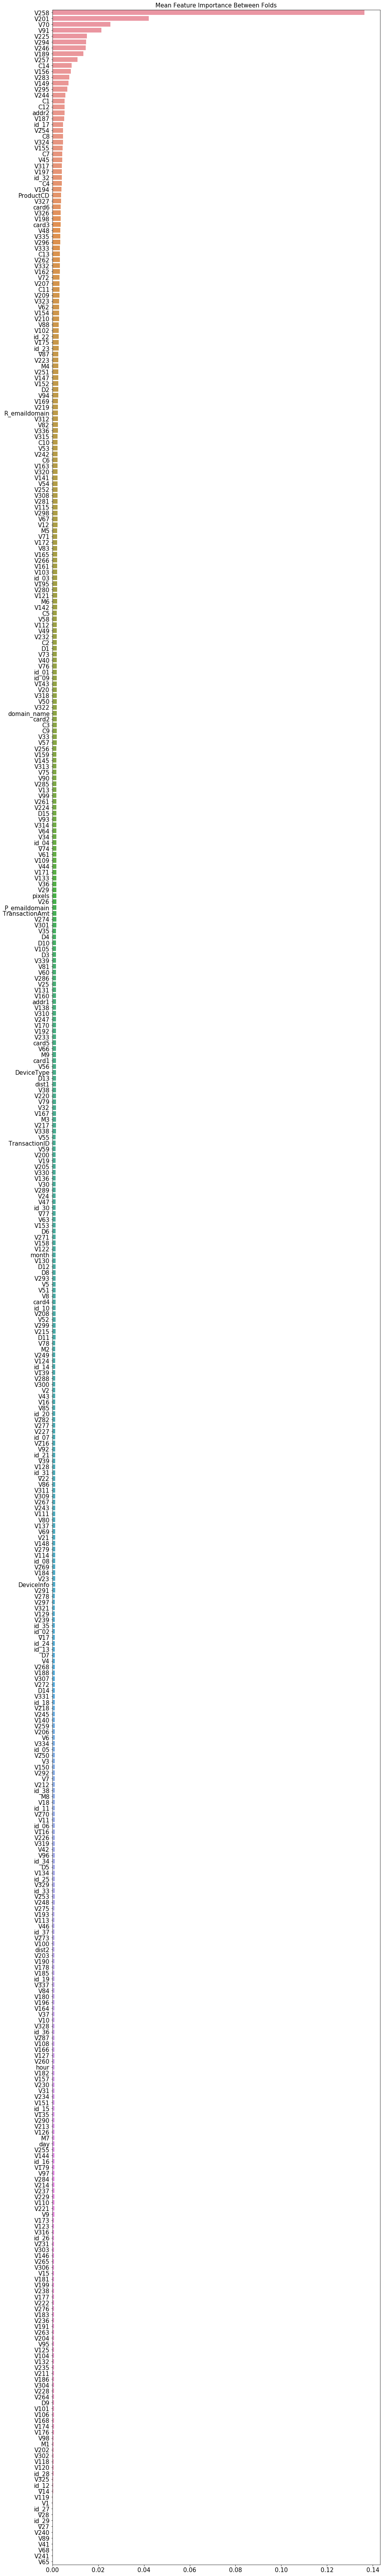

In [13]:
importance['Mean_Importance'] = importance.sum(axis=1) / N
importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 120))
sns.barplot(x='Mean_Importance', y=importance.index, data=importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Mean Feature Importance Between Folds', size=15)

plt.show()

In [14]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')
submission['isFraud'] = y_pred
submission.to_csv('submission.csv')

In [15]:
submission.head()

,isFraud
TransactionID,
3663549,0.002585
3663550,0.001385
3663551,0.003605
3663552,0.001717
3663553,0.001141
